# My_Resnet9

In [17]:
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import numpy as np
import torch
import os
from tqdm import tqdm as tqdm
import time

# from models.my_model import MyNet, train, evaluate, evaluate_test
from torchvision import datasets, transforms

load data

In [28]:
PATH="data/cifar-10-python.tar.gz"

module_path = os.path.dirname(os.getcwd())
home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

# transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#data augmentation
transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            # transforms.RandomErasing(p = 0.5),
        ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

        
# # load dataset from cifar10
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

validset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=False, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# choose device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name(3))

batch_size=64
module_path = os.path.dirname(os.getcwd())
home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
cuda
NVIDIA GeForce RTX 3090


In [20]:
def conv_bn(channels_in, channels_out, kernel_size=3, stride=1, padding=1, groups=1, bn=True, activation=True):
    op = [
            nn.Conv2d(channels_in, channels_out,
                            kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(inplace=True),
    ]
    return nn.Sequential(*op)


class Residual(torch.nn.Module):
    def __init__(self, module):
        super(Residual, self).__init__()
        self.module = module

    def forward(self, x):
        return x + self.module(x)

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        x.view(batch_size, -1).size()
        return x.view(batch_size, -1)
        
def build_network(num_classes=10):
    return nn.Sequential(
        conv_bn(3, 64, kernel_size=3, stride=1, padding=1),
        conv_bn(64, 128, kernel_size=3, stride=1, padding=1),
        # torch.nn.MaxPool2d(2),

        Residual(torch.nn.Sequential(
            conv_bn(128, 128),
            conv_bn(128, 128),
        )),

        conv_bn(128, 256, kernel_size=3, stride=1, padding=1),
        torch.nn.MaxPool2d(2),

        Residual(torch.nn.Sequential(
            conv_bn(256, 256),
            conv_bn(256, 256),
        )),

        conv_bn(256, 128, kernel_size=3, stride=1, padding=0),
        
        # nn.Dropout(p=0.1),
        torch.nn.AdaptiveMaxPool2d((1, 1)),
        Flatten(),
        torch.nn.Linear(128, num_classes, bias=False),
    )
#net

In [23]:
def train(model, device, train_dataloader, optimizer,scheduler, epoch, loss_fn):
    model.train()
    total_loss = 0.
    correct = 0.
    total_len = len(train_dataloader.dataset)

    for idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        preds = model(data) # batch_size * 10
        loss = loss_fn(preds, target)
        total_loss += loss_fn(preds, target).item()
        pred = preds.argmax(dim = 1)
        correct += pred.eq(target.view_as(pred)).sum().item()
        # loss = F.nll_loss(preds,target)
        # 前向传播+反向传播+优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if idx % 1000 == 0:
            print("iteration: {};    Loss: {}".format(idx, loss.item()))

    total_loss = total_loss / total_len
    acc = correct/total_len
    return total_loss, acc

def evaluate(model, device, valid_dataloader,loss_fn, flag):
    model.eval()
    total_loss = 0.
    correct = 0.
    total_len = len(valid_dataloader.dataset)
    with torch.no_grad():
        for idx, (data, target) in enumerate(valid_dataloader):
            
            data, target = data.to(device), target.to(device)
            output = model(data) # batch_size * 1
            total_loss += loss_fn(output, target).item()
            # total_loss += F.nll_loss(output, target, reduction = "sum").item()
            pred = output.argmax(dim = 1)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    total_loss = total_loss / total_len
    acc = correct/total_len
    if flag == 1:
        print("Accuracy on test set:{}".format(acc)) 
    else:
        print("valid loss:{}, Accuracy:{}".format(total_loss, acc)) 
    return total_loss, acc

In [29]:
# hyper parameter
lr = 0.04
momentum = 0.9
weight_decay = 4e-4
num_features = 3
hidden_size = 1024
output_size = 10
loss_fn = nn.CrossEntropyLoss()

# model = ResNet(num_features,hidden_size,output_size).to(device)
model = build_network(output_size).to(device)
#选择一个optimizer
#SGD/ADAM
# optimizer1 = torch.optim.SGD(model.parameters(), lr = lr, momentum=momentum,weight_decay=weight_decay)
optimizer2 = torch.optim.SGD(model.parameters(), lr = 0.04, momentum=momentum, weight_decay=weight_decay)
#cyclicLR
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer2, base_lr=0.01, max_lr=0.04)

starttime = time.time()
num_epochs = 50
total_loss = []
train_loss= []
acc = []
train_acc =[]

train_loss1, train_acc1 = train(model, device, train_dataloader,optimizer2, scheduler, 0, loss_fn)
total_loss_0, acc_0 = evaluate(model, device, valid_dataloader,loss_fn, 0)
torch.save(model.state_dict(),"CIFAR10_cnn.pth")    
total_loss.append(total_loss_0)
acc.append(acc_0)
train_loss.append(train_loss1)
train_acc.append(train_acc1)

for epoch in range(1,num_epochs):
    print("Training epoch:", epoch)
    train_loss1, train_acc1 = train(model, device, train_dataloader, optimizer2, scheduler, epoch, loss_fn)
    
    total_loss_0, acc_0 = evaluate(model, device, valid_dataloader,loss_fn, 0)
    if total_loss_0 < min(total_loss) and acc_0 > max(acc):
        torch.save(model.state_dict(),"CIFAR10_cnn.pth")
    total_loss.append(total_loss_0)
    acc.append(acc_0)
    train_loss.append(train_loss1)
    train_acc.append(train_acc1)

model_ready = build_network(output_size).to(device)
model_ready.load_state_dict(torch.load('CIFAR10_cnn.pth'))
evaluate(model_ready, device, test_dataloader,loss_fn, 1)

endtime = time.time()
dtime = endtime - starttime
print("Finish! run time: %.8s s" % dtime)

iteration: 0;    Loss: 3.3359837532043457
valid loss:0.021204094290733336, Accuracy:0.5109
Training epoch: 1
iteration: 0;    Loss: 1.442030429840088
valid loss:0.015102761048078537, Accuracy:0.6536
Training epoch: 2
iteration: 0;    Loss: 1.178421139717102
valid loss:0.013139841023087502, Accuracy:0.7055
Training epoch: 3
iteration: 0;    Loss: 0.8555993437767029
valid loss:0.010384639728069306, Accuracy:0.7692
Training epoch: 4
iteration: 0;    Loss: 0.7030922770500183
valid loss:0.008058884987235069, Accuracy:0.8203
Training epoch: 5
iteration: 0;    Loss: 0.7195666432380676
valid loss:0.009861502802371979, Accuracy:0.7896
Training epoch: 6
iteration: 0;    Loss: 0.5218578577041626
valid loss:0.009413931673765183, Accuracy:0.7955
Training epoch: 7
iteration: 0;    Loss: 0.44717463850975037
valid loss:0.00857535389959812, Accuracy:0.8114
Training epoch: 8
iteration: 0;    Loss: 0.5027187466621399
valid loss:0.007105977475643158, Accuracy:0.8436
Training epoch: 9
iteration: 0;    Loss

In [30]:
# test part
model_ready = build_network(output_size).to(device)
model_ready.load_state_dict(torch.load('CIFAR10_cnn.pth'))
evaluate(model_ready, device, test_dataloader,loss_fn, 1)

endtime = time.time()
dtime = endtime - starttime
print("Finish! run time: %.8s s" % dtime)

Accuracy on test set:0.9111
Finish! run time: 1344.694 s


参数个数

In [25]:
def cal_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
model = build_network(output_size).to(device)
print(cal_parameters(model))

2143808


画图

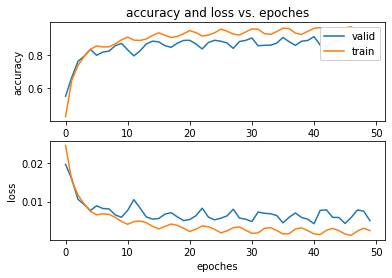

In [27]:
x1 = range(0, num_epochs)
x2 = range(0, num_epochs)
# x3 = range(0,49)
y1 = acc
y2 = total_loss
y11 = train_acc
y22 = train_loss
# 绘制结果
plt.clf()
plt.subplot(2, 1, 1)
# plt.ylim(0.4,0.95)
plt.plot(x1, y1)
plt.plot(x1, y11)
plt.title('accuracy and loss vs. epoches')
plt.ylabel('accuracy')
l1 = plt.legend( ["valid", "train"], loc='upper right')
plt.gca().add_artist(l1)

plt.subplot(2, 1, 2)
plt.plot(x2, y2)
plt.plot(x2,y22)
plt.xlabel('epoches')
plt.ylabel('loss')



plt.savefig("newNet_compare.jpg")